In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 7)
plt.set_cmap("viridis")

import itertools
import numpy as np

In [2]:
from carl.distributions import Normal
from carl.data import GK

true_A = 3.    # Parameter
true_B = 1.5   # Parameter
true_g = 2.    # Nuisance parameter
true_k = 0.5   # Constant

gk = GK(A=true_A, B=true_B, g=true_g, k=true_k)
X_true = gk.rvs(10000)

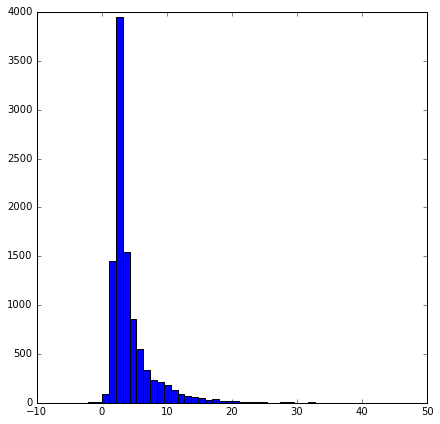

In [3]:
_ = plt.hist(X_true, bins=40)

In [ ]:
from carl.learning import as_classifier
from carl.learning import make_parameterized_classification
from carl.learning import ParameterizedClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Build classification data
p1 = Normal(mu=np.mean(X_true), 
            sigma=np.std(X_true) * 4)

X, y = make_parameterized_classification(
    gk, p1, 200000, 
    [(gk.A, np.linspace(1, 5, num=20)), 
     (gk.B, np.linspace(1, 5, num=20)),
     (gk.g, np.linspace(1, 5, num=20))])

# Train parameterized classifier
clf = ParameterizedClassifier(
    make_pipeline(StandardScaler(), 
                  as_classifier(MLPRegressor(learning_rate="adaptive", 
                                             hidden_layer_sizes=(100, 100)))),
    [gk.A, gk.B, gk.g])
clf.fit(X, y)

In [14]:
from GPyOpt.methods import BayesianOptimization

from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio

def vectorize(func):
    def wrapper(x):
        v = np.zeros(len(x))
        
        for i, x_i in enumerate(x):
            v[i] = func(x_i)
        return v.reshape(-1, 1)
    
    return wrapper

def objective(theta, random_state=0): 
    print(theta)
    
    # Set parameter values
    gk.A.set_value(theta[0])
    gk.B.set_value(theta[1])
    
    # Optimize over the nuisance parameter g, at fixed values A and B
    def objective_g(g):
        gk.g.set_value(g[0])

        # Fit ratio
        ratio = ClassifierRatio(CalibratedClassifierCV(
            base_estimator=clf, 
            cv="prefit",  # keep the pre-trained classifier
            method="isotonic"))
        ratio.fit(numerator=gk, denominator=p1, n_samples=5000)

        # Evaluate log-likelihood ratio
        r = ratio.predict(X_true, log=True)
        value = -np.mean(r[np.isfinite(r)])
        
        return value
    
    
    solver = BayesianOptimization(vectorize(objective_g), [(1, 5)])
    solver.run_optimization(max_iter=15, true_gradients=False)
    
    return solver.fx_opt

In [ ]:
solver = BayesianOptimization(vectorize(objective), [(1, 5), (1, 5)])
solver.run_optimization(max_iter=100, true_gradients=False)

In [19]:
solver.x_opt, solver.fx_opt

(array([ 2.92990723,  1.57714945]), array([-1.58365736]))

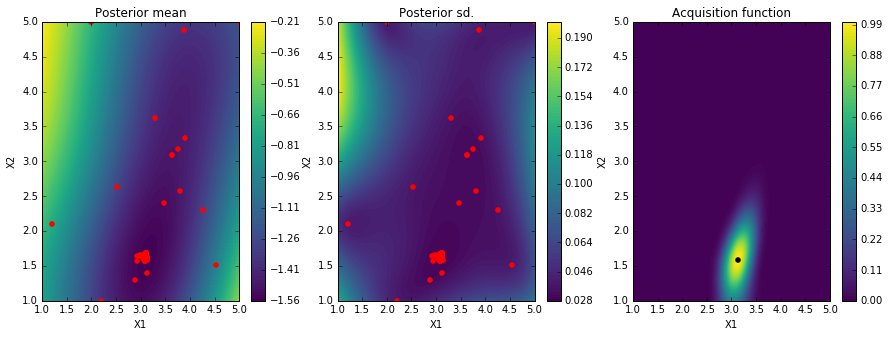

In [17]:
solver.plot_acquisition()

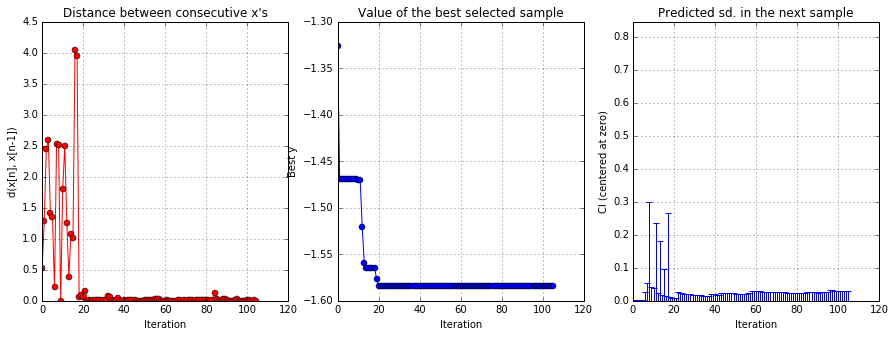

In [18]:
solver.plot_convergence()